In [1]:
from scipy.stats import alpha
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [2]:
import sqlite3
import pandas as pd
import seaborn as sns

with sqlite3.connect('../data/models.db') as conn:
    df = pd.read_sql('SELECT * FROM models WHERE exp_id=0', conn)

for col in ['val_acc', 'train_acc', 'time', 'flops', 'macs', 'params', 'exp_id']:
    df[col] = df[col].apply(eval)
    
df.sort_values(by='val_acc', ascending=False, inplace=True)

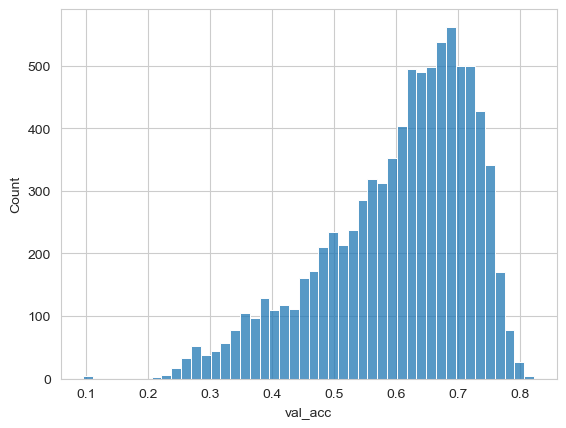

In [3]:
sns.histplot(df.val_acc);

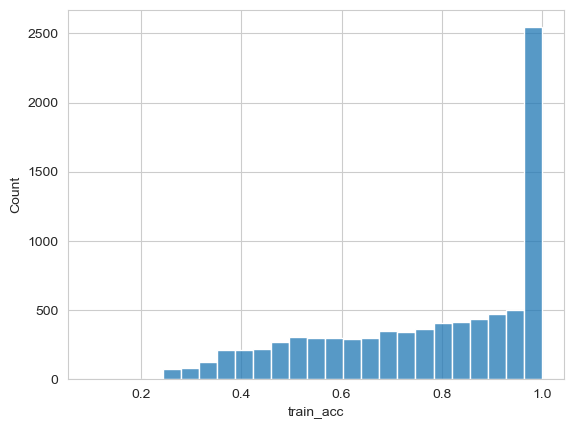

In [4]:
sns.histplot(df.train_acc);

In [5]:
from sophius.encode import Encoder, str_to_vec

encoder = Encoder()

df['vec'] = df['hash'].apply(str_to_vec)
df['seq_len'] = df.vec.apply(len)

C:\Users\korol\miniforge3\envs\sophius\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


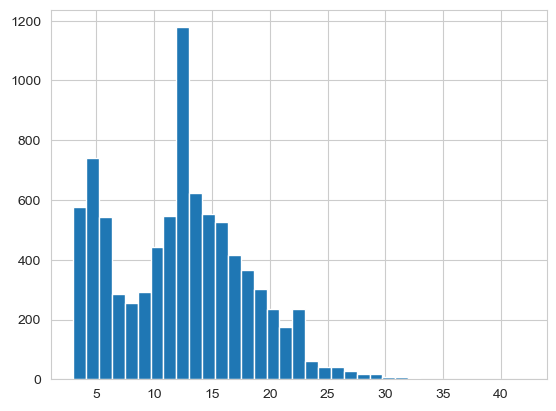

In [6]:
df.seq_len.hist(bins=35);

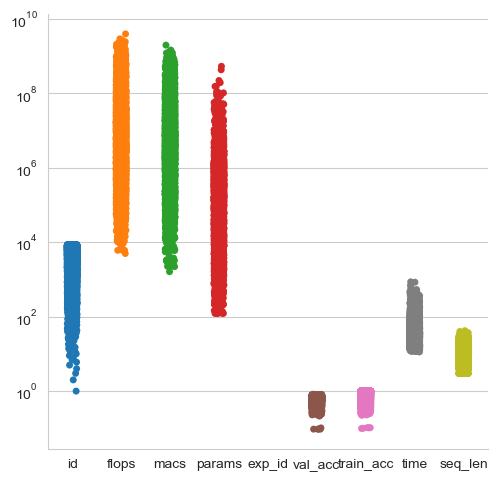

In [7]:
import matplotlib.pyplot as plt
sns.catplot(df);
plt.yscale('log')

In [8]:
# df.query('seq_len > 8').seq_len.hist(bins=25)

In [9]:
# df = df.query('seq_len > 8')
# df = df.query('val_acc >')

In [10]:
import torch
import pytorch_lightning as pl
from torch.utils.data import random_split
from sophius.dataload import SequenceLoader, SequenceDataset

RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)

dataset = SequenceDataset(df.vec.tolist(), df.val_acc.values)
train, val = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(RANDOM_SEED))

In [11]:
import pytorch_lightning as pl
import torch
from torch.nn import functional as F


class LSTMLightning(pl.LightningModule):
    def __init__(self,
                 input_dim=32,
                 hidden_dim=128,
                 num_layers=1,
                 dropout=0.0,
                 lr=1e-3,
                 gamma=0.9,                 
                 **_):
        super().__init__()
        self.save_hyperparameters()  # Save hyperparameters
        self.lstm = torch.nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, 1)
        self.lr = lr
        self.gamma = gamma
        self.val_loss = None

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])

    def training_step(self, batch, batch_idx):
        sequences, targets = batch
        outputs = self(sequences)
        targets = targets.view(-1, 1)
        loss = F.mse_loss(outputs, targets)
        self.log('train_loss', loss, on_step=True, on_epoch=False, prog_bar=False)
        # self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        sequences, targets = batch
        outputs = self(sequences)
        targets = targets.view(-1, 1)
        loss = F.mse_loss(outputs, targets)
        self.log('val_loss', loss, on_step=True, on_epoch=False, prog_bar=False)
        self.val_loss.append(loss)
        return loss

    def on_validation_epoch_start(self) -> None:
        self.val_loss = []

    def on_validation_epoch_end(self):
        avg_val_loss = torch.mean(torch.stack(self.val_loss))
        # print('val', avg_val_loss, len(self.val_loss))
        self.log('hp_metric', avg_val_loss)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.lr)
        return {
            'optimizer': opt,
            'lr_scheduler': torch.optim.lr_scheduler.ExponentialLR(opt, gamma=self.gamma)
        }

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def plot_results(model, dataset):
    # plt.figure(figsize=(6, 6))
    # plt.gca().set_aspect('equal', adjustable='box')
    res = pd.DataFrame(columns=['y_pred', 'y_true'])
    model.eval()
    model = model.cuda()
    
    with torch.no_grad():
        for seq, y_true in dataset:
            y_pred = model(seq.unsqueeze(0)).item()
            y_true = y_true.item()
            res.loc[len(res)] = [y_pred, y_true]
    
    print(f'MSE: {mean_squared_error(res.y_true, res.y_pred):.4f}')
    print(f'R^2: {r2_score(res.y_true, res.y_pred):.4f}')
    sns.regplot(res, x='y_pred', y='y_true')#.set_aspect('equal', adjustable='datalim')

<Axes: >

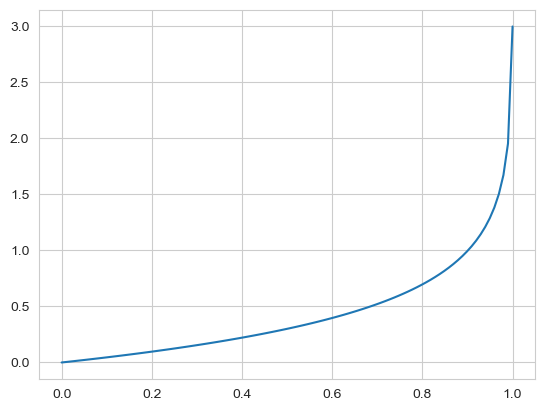

In [13]:
import numpy as np

def func(x, eps=1e-3):
    return -np.log10(1 + eps - x)
    
x = np.linspace(0, 1, 100)
y = func(x)

sns.lineplot(x=x, y=y)

## Train lightning model

In [14]:
import warnings
from tqdm import tqdm
from pytorch_lightning.callbacks import TQDMProgressBar

# disable validation bar, buggy in pycharm
class CustomProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        return tqdm(disable=True)

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

hparams = {
    'lr': 1e-3,
    'gamma': 1,
    'hidden_dim': 32,
    'num_layers': 2,
    'dropout': 0.5,
    'input_dim': 32,
    'num_epochs': 20,
    'batch_size': 8,
}

# train_loader = DataLoader(train, batch_size=1, shuffle=False, num_workers=0)
# val_loader = DataLoader(val, batch_size=1, shuffle=False, num_workers=0)
# train_loader = SimpleLoader(train)
# val_loader = SimpleLoader(val)
train_loader = SequenceLoader(train, batch_size=hparams['batch_size'])
val_loader = SequenceLoader(val, batch_size=hparams['batch_size'])

# Initialize model
model = LSTMLightning(**hparams)

# Create PyTorch Lightning trainer
trainer = pl.Trainer(
    max_epochs=hparams['num_epochs'], 
    accelerator='gpu', 
    log_every_n_steps=4,
    callbacks=[CustomProgressBar()],
)

# Train the model
model.train()
# print(model.device)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | lstm | LSTM   | 16.9 K
1 | fc   | Linear | 33    
--------------------------------
16.9 K    Trainable params
0         Non-trainable params
16.9 K    Total params
0.068     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 1066/1066 [00:07<00:00, 151.06it/s, loss=0.00137, v_num=37]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1066/1066 [00:07<00:00, 150.91it/s, loss=0.00137, v_num=37]


MSE: 0.0016
R^2: 0.8866


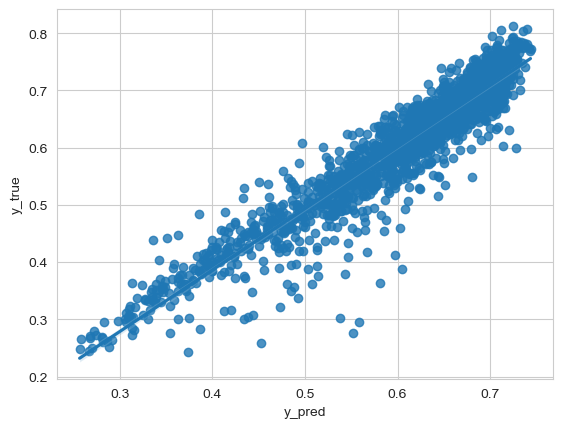

In [16]:
plot_results(model, val);

## Train torch model

In [17]:
from sophius.estimate import LSTMRegressor

reg = LSTMRegressor(**hparams).cuda()

opt = torch.optim.Adam(reg.parameters(), lr=hparams['lr'])
sch = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=hparams['gamma'])
loader = SequenceLoader(dataset, batch_size=hparams['batch_size'])

reg.train()
for i in tqdm(range(hparams['num_epochs']), desc='Epoch'):
    for (x, y) in loader:
        y_pred = reg(x)
        loss = F.mse_loss(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        sch.step()
        
torch.save(reg, '../data/models/estimator_v2.pth')

Epoch: 100%|██████████| 20/20 [01:53<00:00,  5.70s/it]
